### NYC Taxi Duration Regression:

Building a regression model for predicting duration of taxi rides given a set of input features as follows:

- VendorID
- lpep_pickup_datetime
- lpep_dropoff_datetime
- store_and_fwd_flag - Flag to determine if record was held in vehicle memoruy before sending to server due to lack of connection. 
- RatecodeID
- PULocationID - Pickup location ID.
- DOLocationID - DropOff location ID. 
- passenger_count
- trip_distance - Provided as miles.
- fare_amount
- extra
- mta_tax
- tip_amount
- tolls_amount
- ehail_fee
- improvement_surcharge
- total_amount
- payment_type
- trip_type
- congestion_surcharge


Import Packages:

In [121]:
import pandas as pd
import pickle
import numpy as np

# Visualisation Imports
import seaborn as sns
sns.color_palette("husl", 8)
sns.color_palette("mako", as_cmap=True)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Modelling Imports:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Read in Data:

In [2]:
taxi_data = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

In [3]:
taxi_data.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
4         2  2021-01-01 00:16:36   2021-01-01 00:16:40                  N   

   RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
0         1.0            43           151              1.0           1.01   
1         1.0           166           239              1.0           2.53   
2         1.0            41            42              1.0           1.12   
3         1.0           168            75              1.0           1.99   
4         2.0           265           265              3.0           0.00   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount ehail_fee  \
0          5.5    0.5      0.5        0.00           0.0      None   
1         10.0    0.5      0.5        2.81           0.0      None   
2          6.0    0.5      0.5        1.00           0.0      None   
3          8.0    0.5      0.5        0.00           0.0      None   
4        -52.0    0.0     -0.5        0.00           0.0      None   

   improvement_surcharge  total_amount  payment_type  trip_type  \
0                    0.3          6.80           2.0        1.0   
1                    0.3         16.86           1.0        1.0   
2                    0.3          8.30           1.0        1.0   
3                    0.3          9.30           2.0        1.0   
4                   -0.3        -52.80           3.0        1.0   

   congestion_surcharge  
0                  0.00  
1                  2.75  
2                  0.00  
3                  0.00  
4                  0.00

In [4]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[ns]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

Adding column for duration of trip:

In [58]:
taxi_data["duration"] = taxi_data["lpep_dropoff_datetime"].subtract(taxi_data["lpep_pickup_datetime"])
taxi_data["duration(mins)"] = taxi_data["duration"].apply(lambda x : x.total_seconds()/60)

In [59]:
taxi_data.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
7         2  2021-01-01 00:26:31   2021-01-01 00:28:50                  N   

   RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0         1.0           43          151              1.0           1.01   
1         1.0          166          239              1.0           2.53   
2         1.0           41           42              1.0           1.12   
3         1.0          168           75              1.0           1.99   
7         1.0           75           75              6.0           0.45   

   fare_amount  ...  tip_amount  tolls_amount  ehail_fee  \
0          5.5  ...        0.00           0.0       None   
1         10.0  ...        2.81           0.0       None   
2          6.0  ...        1.00           0.0       None   
3          8.0  ...        0.00           0.0       None   
7          3.5  ...        0.96           0.0       None   

   improvement_surcharge total_amount  payment_type  trip_type  \
0                    0.3         6.80           2.0        1.0   
1                    0.3        16.86           1.0        1.0   
2                    0.3         8.30           1.0        1.0   
3                    0.3         9.30           2.0        1.0   
7                    0.3         5.76           1.0        1.0   

   congestion_surcharge        duration  duration(mins)  
0                  0.00 0 days 00:03:56        3.933333  
1                  2.75 0 days 00:08:45        8.750000  
2                  0.00 0 days 00:05:58        5.966667  
3                  0.00 0 days 00:07:05        7.083333  
7                  0.00 0 days 00:02:19        2.316667  

[5 rows x 22 columns]

### Exploring Data:

In [60]:
num_data = taxi_data.select_dtypes(['number'])

/var/folders/bn/m0fctgmn5t753x60khg3_q2m0000gn/T/ipykernel_70130/1032722487.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

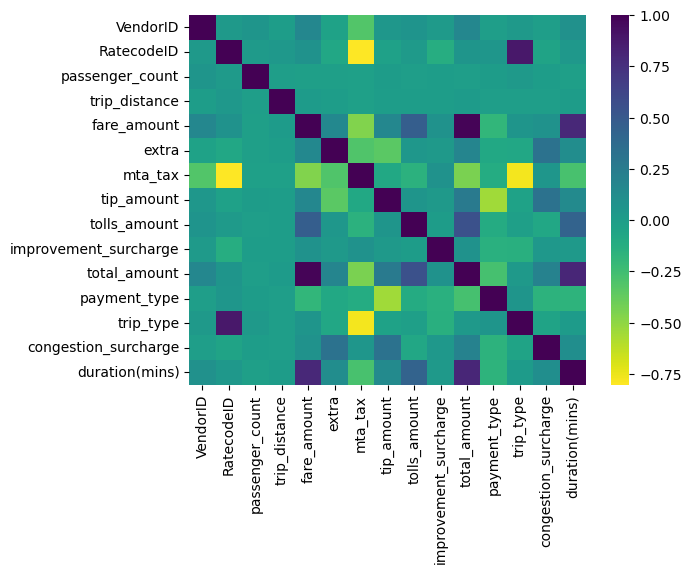

In [61]:
sns.heatmap(num_data.corr(), cmap="viridis_r")

In [62]:
fig_duration = px.histogram(taxi_data, x="duration(mins)")
fig_duration.update_layout(title="Distirbution Count of Durations", xaxis_range=[0, 200], yaxis={"title" : "Count"})
fig_duration.show()

In [63]:
fig_duration_percent = px.box(taxi_data, y="duration(mins)", notched=True)
fig_duration_percent.update_layout(yaxis_range=[0, 60], title="Box Plot of Trip Durations")
fig_duration_percent.show()

In [64]:
percentiles = np.percentile(taxi_data["duration(mins)"], np.arange(0, 100, 2.5))
fig_percentile = go.Figure(go.Scatter(x=np.arange(0, 100, 2.5), y=percentiles))
fig_percentile.update_layout(title="Percentile Plot of Trip Durations(Mins)", xaxis={"title" :"Percentile"}, yaxis={"title" : "Duration(Mins)"})
fig_percentile.show()


We can see the more than 97.5% of our journeys have duration less than 60mins, so it's sensible to build our regression model using trips with a duration greater than 1 minute, but less than 60.

In [65]:
taxi_data = taxi_data.loc[(taxi_data["duration(mins)"] >= 1) & (taxi_data["duration(mins)"] <= 60)]

### Baselining Performance:

Baseline performance using intuitive features:

The intuitive features are the features I think make sense to use in predicting length of trip:

- Time of starting trip, (not end as this is not available at in time of inference)
- Trip distance. 
- Starting location. 
- Ending location.

In [78]:
taxi_data["Day"] = taxi_data["lpep_pickup_datetime"].apply(lambda x : x.weekday())
taxi_data["Pick_Up_Time"] = taxi_data["lpep_pickup_datetime"].apply(lambda x : x.time())
taxi_data["Pick_Up_Hour"] = taxi_data["lpep_pickup_datetime"].dt.round('H').dt.hour

In [79]:
taxi_data.head()

VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
0         2  2021-01-01 00:15:56   2021-01-01 00:19:52                  N   
1         2  2021-01-01 00:25:59   2021-01-01 00:34:44                  N   
2         2  2021-01-01 00:45:57   2021-01-01 00:51:55                  N   
3         2  2020-12-31 23:57:51   2021-01-01 00:04:56                  N   
7         2  2021-01-01 00:26:31   2021-01-01 00:28:50                  N   

   RatecodeID PULocationID DOLocationID  passenger_count  trip_distance  \
0         1.0           43          151              1.0           1.01   
1         1.0          166          239              1.0           2.53   
2         1.0           41           42              1.0           1.12   
3         1.0          168           75              1.0           1.99   
7         1.0           75           75              6.0           0.45   

   fare_amount  ...  improvement_surcharge  total_amount  payment_type  \
0          5.5  ...                    0.3          6.80           2.0   
1         10.0  ...                    0.3         16.86           1.0   
2          6.0  ...                    0.3          8.30           1.0   
3          8.0  ...                    0.3          9.30           2.0   
7          3.5  ...                    0.3          5.76           1.0   

   trip_type congestion_surcharge        duration  duration(mins)  Day  \
0        1.0                 0.00 0 days 00:03:56        3.933333    4   
1        1.0                 2.75 0 days 00:08:45        8.750000    4   
2        1.0                 0.00 0 days 00:05:58        5.966667    4   
3        1.0                 0.00 0 days 00:07:05        7.083333    3   
7        1.0                 0.00 0 days 00:02:19        2.316667    4   

   Pick_Up_Time  Pick_Up_Hour  
0      00:15:56             0  
1      00:25:59             0  
2      00:45:57             1  
3      23:57:51             0  
7      00:26:31             0  

[5 rows x 25 columns]

In [88]:
fig_time = px.histogram(taxi_data, x="Pick_Up_Hour", opacity=0.8, color_discrete_sequence=['indianred'])
fig_time.update_layout(bargap=0.2, title="Pick Up Time Distribution Plot", 
                       xaxis={"title" : "Pick Up Hour", "tickmode" : "linear", "tick0" : 0, "dtick" : 1},
                       yaxis={"title" : "Count"})
fig_time.show()

In [109]:
base_features = ["PULocationID", "DOLocationID", "trip_distance", "Day", "Pick_Up_Hour"]

Convert categorical features into strings for OneHotEncoding:

In [106]:
one_hot_ftrs = ["PULocationID", "DOLocationID", "Pick_Up_Hour", "Day"]
taxi_data[one_hot_ftrs]= taxi_data[one_hot_ftrs].astype(str)

Train and Fit Model:

In [110]:
train_dicts = taxi_data[base_features].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration(mins)'
y_train = taxi_data[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.761999604602664

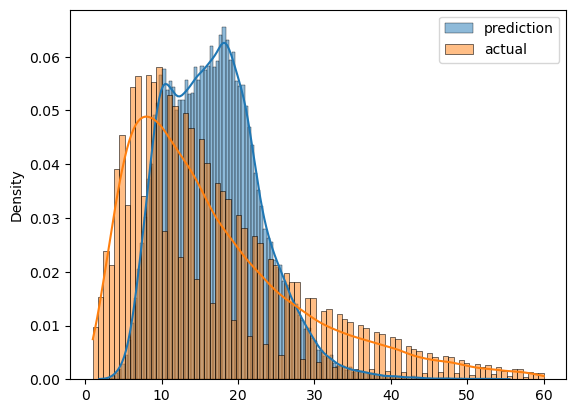

In [111]:
sns.histplot(y_pred, label='prediction', kde=True, stat="density")
sns.histplot(y_train, label='actual', kde=True, stat="density")

plt.legend()

In [120]:
num_sample = 200
fig_predicted = go.Figure(go.Scatter(x=np.arange(0, num_sample), y=y_pred[: num_sample], mode="markers", name="Predicted"))
fig_predicted.add_trace(go.Scatter(x=np.arange(0, num_sample), y=y_train[: num_sample], mode="markers", name="Actual"))
fig_predicted.update_layout(title="Predicted Values vs Actual Values", xaxis={"title" : "DataPoint Number"}, yaxis={"title" : "Duration(Mins)"})
fig_predicted.show()

Save Model: storing the DictVectorizer and the regression model.

In [123]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)